# Counting experiment

- We observe a total number of $n = b+s$ events

- $s$ is the parameter of interest, $b$ is a nuisance parameter

- The likelihood $\mathcal{L}$ to observe $n$ events when the expected signal and background yields are $s$ and $b$ respectively is the Poissonian $\mathcal{P}$ with mean $s + b$ calculated at $n$

\begin{equation}
\mathcal{L}(s,b|n) = \mathcal{P}(n|s+b)
\end{equation}

- Place confidence interval both with a frequentist and bayesian technique on the number of signal events $s$

- Here we define some utils that will be useful for later calculation

#### Utils

In [8]:
from scipy.stats import poisson,norm
from math import log
from scipy.integrate import simpson
from scipy.optimize import minimize
from functools import partial
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumulative_trapezoid

def model_poisson(n,s,b):
    return poisson(s+b).pmf(n)

def prior_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

def constraint_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

# prior_b and constraint_b practically equal, conceptually different
def model_constraint_bayes(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*prior_b(b,bbar,sigmab)
    
def model_constraint_freq(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*constraint_b(bbar,b,sigmab)

def model_poisson_2d(n,x):
    s = x[0]
    b = x[1]
    return model_poisson(n,s,b)
    
def model_constraint_2d_freq(n,x,bbar,sigmab):
    s = x[0]
    b = x[1]
    return model_constraint_freq(n,s,b,bbar,sigmab)

def nll(model,n,s,b,**kwargs):
    return -np.log(model(n,s,b,**kwargs))

def nll_2d(model,n,x,**kwargs):
    return -np.log(model(n=n,x=x,**kwargs))

def integral_2d(f,x,y):
    zz = f(x.reshape(-1,1),y.reshape(1,-1))
    return simpson([simpson(zz_y,y) for zz_y in zz],x) 
    
def posterior(model,n,b=None,s=np.linspace(0,10,101),profile_b=False,TwoD = False,**kwargs):
    if type(b) is int or type(b) is float: # fixed b
        integralmodel = quad(partial(model,n,b=b,**kwargs),0,np.inf)[0]
        return model(n,s,b,**kwargs)/integralmodel
    else: # b not fixed
        if profile_b: # optimise b
            post = []
            for s_i in s:
                res=minimize(partial(nll,model,n,s_i,**kwargs),x0=(3,),bounds=[(0,np.inf)])
                optimalb = res.x[0]
                post.append(model(n=n,s=s_i,b=optimalb,**kwargs))
            post = np.array(post)
            integralmodel = simpson(post,s)
            return post/integralmodel
        else: # integrate b
            post = []
            integral = integral_2d(partial(model,n,**kwargs),s,b)
            if TwoD: # Posterior 2D (s,b)
                return model(n,s = s.reshape(1,-1),b = b.reshape(-1,1),**kwargs)/integral
            else: # Posterior 1D (s) / integrate b
                integral_b = simpson(model(n,s.reshape(-1,1),b.reshape(1,-1),**kwargs),b,axis=1)
                return integral_b/integral

def testStatistic(model,n,s,b,bestNLL,**kwargs):
    return 2*(nll(model=model,n=n,s=s,b=b,**kwargs)-bestNLL)

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

## Bayesian approach

- The posterior is given by (Bayes theorem)

\begin{equation}
\mathrm{posterior}(s,b) = \frac{\mathcal{L}(s, b|n) \, \mathrm{prior}(s) \mathrm{prior}(b) }{\int \int \mathcal{L}(s' , b'|n) \, \mathrm{prior}(s') \, \mathrm{prior}(b') \, ds' \, db'}
\end{equation}

- The prior for $s$ is uniform in the interval $s\geq 0$, and the posterior reduces to

\begin{equation}
\mathrm{posterior}(s,b) = \frac{\mathcal{L}(s , b|n) \,\mathrm{prior}(b) }{\int \int_0^\infty \mathcal{L}(s' , b'|n) \,\mathrm{prior}(b') \, ds' \, db'}
\end{equation}

In the bayesian statistics, once you have the posterior you have “everything”, you can calculate intervals, upper limits, ...

### Fixed number of background yield

- In case the background yield $b=\overline{b}$ is known, $\mathrm{prior}(b) = \delta(b-\overline{b})$ and we integrate it out in the posterior

\begin{equation}
\mathrm{posterior}(s|n,\overline{b}) = \frac{\mathcal{L}(s | n,\overline{b})}{\int_0^\infty \mathcal{L}(s' | n,\overline{b}) ds'} = \frac{\mathcal{P}(n|s+\overline{b})}{\int_o^\infty \mathcal{P}(n|s'+\overline{b}) ds'} = \frac{\frac{(s+\overline{b})^n}{n!} e^{-(s+\overline{b})}}{\int_0^\infty \frac{(s'+\overline{b})^n}{n!} e^{-(s'+\overline{b})} ds'}
\end{equation}

- in the particular case $n=0$
\begin{equation}
\mathrm{posterior}(s|0,\overline{b}) = \frac{e^{-(s+\overline{b})}}{\int_0^\infty e^{-(s'+\overline{b})} ds'} = e^{-s}
\end{equation}
the posterior (and then the confidence intervals) are indipendent on the number of expected background!

#### Python

	 n=0 	 n=1 	 n=2 	 n=3 	 n=4
b=0	2.302	3.889	5.322	6.680	7.993
b=1	2.302	3.271	4.442	5.711	6.999
b=2	2.302	2.994	3.877	4.925	6.087
b=3	2.302	2.838	3.522	4.362	5.344
b=4	2.302	2.739	3.288	3.966	4.779


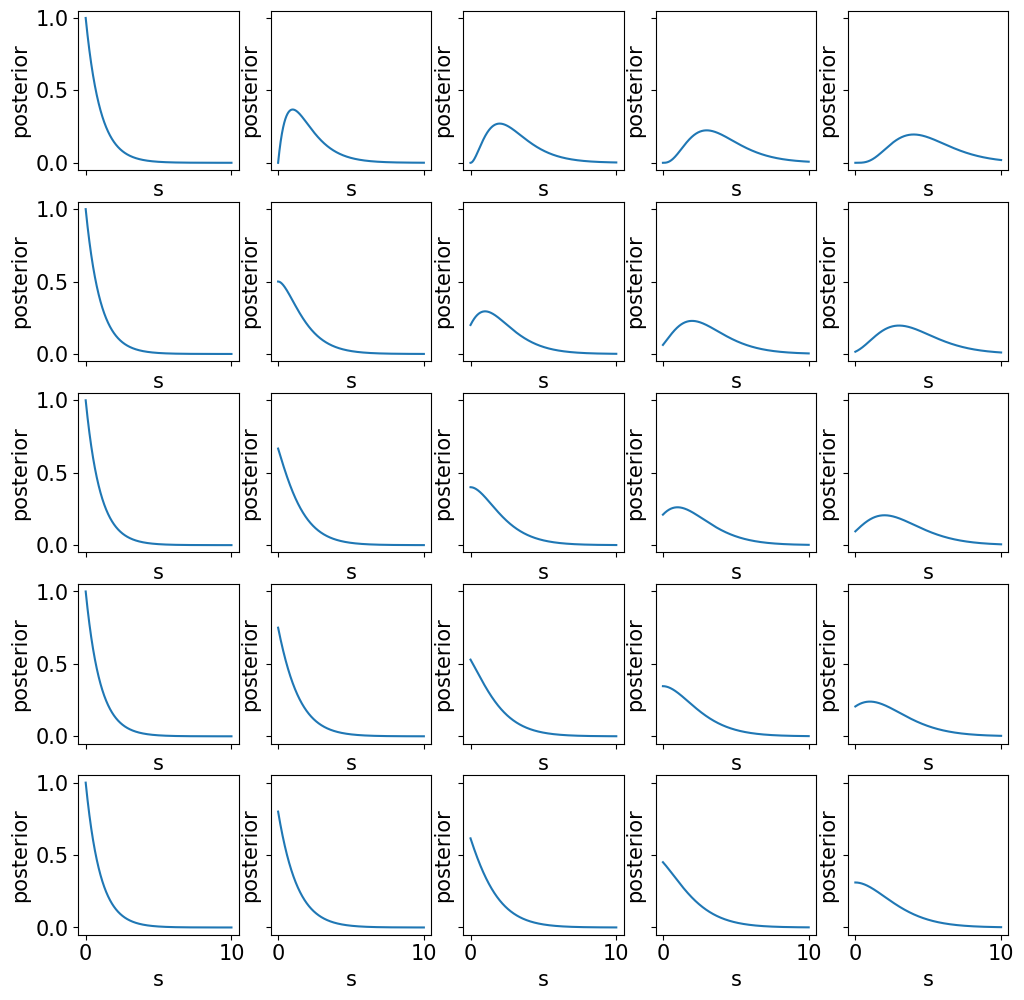

In [10]:
upper_limits = {}
fig,axs=plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12,12))
s = np.linspace(0,10,10001)
for b in range(5):
    for n in range(5):
        post = posterior(model=model_poisson,n=n,b=b,s=s)
        cum_int = cumulative_trapezoid(post,s)
        CL = 0.9
        idx = (cum_int>CL).argmax()
        upper_limits[(n,b)] = s[idx]
        plt.sca(axs[b,n])
        plt.xlabel('s',fontsize=15)
        plt.ylabel('posterior',fontsize=15)
        plt.plot(s,post)

print('\t n=0 \t n=1 \t n=2 \t n=3 \t n=4')
for b in range(0,5):
    print('b='+str(b)+'\t'+( '\t'.join(['%.3f'%upper_limits[(n,b)] for n in range(0,5)]) ) )

#### ROOT - RooStats

	 n=0 	 n=1 	 n=2 	 n=3 	 n=4
b=0	2.303	3.890	5.322	6.679	7.987
b=1	2.303	3.272	4.443	5.711	6.997
b=2	2.303	2.995	3.877	4.926	6.086
b=3	2.303	2.839	3.523	4.362	5.344
b=4	2.303	2.739	3.289	3.967	4.779
[#1] INFO:Minimization -- createConstraintTerm: caching constraint set under name CACHE_CONSTR_OF_PDF_poisson_FOR_OBS_n with 0 entries
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction :  nll value 8 poi value = 8
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction : minimum of NLL vs POI for POI =  1e-05 min NLL = 1e-05
[#1] INFO:Minimization --  Including the following constraint terms in minimization: (prior_s)
[#1] INFO:Minimization -- The following global observables have been defined and their values are taken from the model: ()
[#1] INFO:Eval -- BayesianCalculator: Compute interval using RooFit:  posteriorPdf + createCdf + RooBrentRootFinder 
[#1] INFO:NumericIntegration -- RooRealIntegral::init(_posteriorPdf_likelihood_times_prior_product_poisson_prior_s_cdf_Int[s_p

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


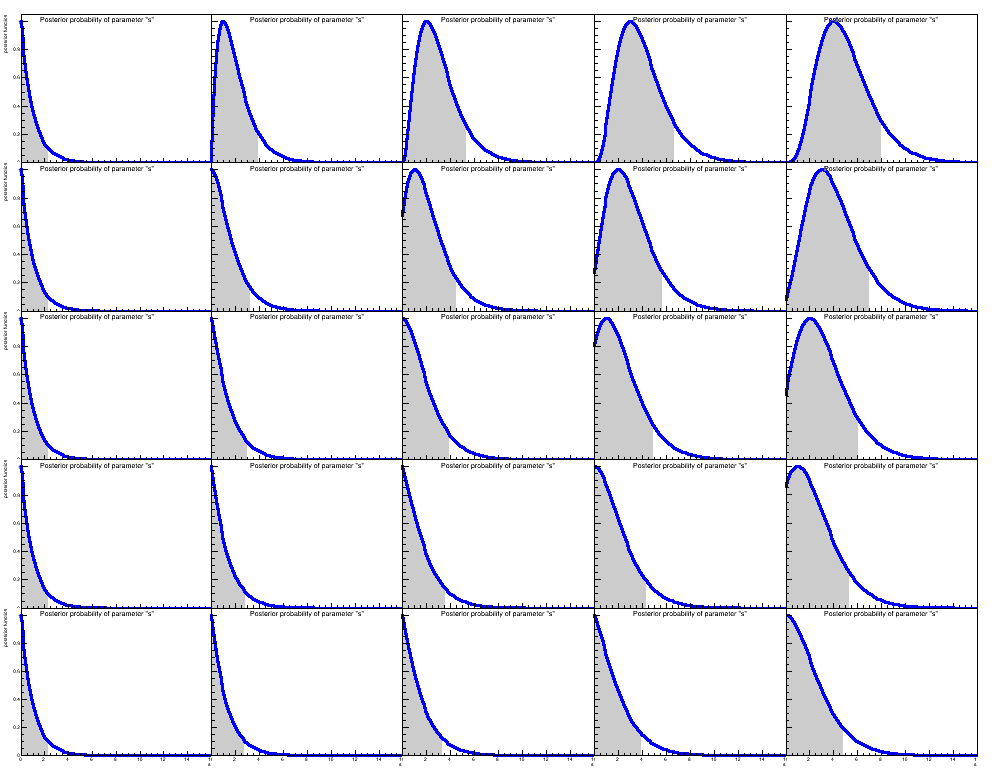

In [11]:
import ROOT

ws = ROOT.RooWorkspace()

ws.factory('expr::splusb(\'s+b\',s[1E-5,16],b[3,0,10])')
ws.factory('Poisson::poisson(n[0,100],splusb)')

ws.factory('Uniform::prior_s(s)') # prior signal
ws.factory('Gaussian::prior_b(b,3,sigmab[0.5,0.05,5.0])') # background with gaussian uncertainty
ws.factory('PROD::prior(prior_s,prior_b)')

modelc = ROOT.RooStats.ModelConfig(ws)
modelc = ROOT.RooStats.ModelConfig(ws)
modelc.SetPdf('poisson')
modelc.SetParametersOfInterest('s')
modelc.SetPriorPdf('prior_s')

c = ROOT.TCanvas('c','c',1000,800)
c.Divide(5,5,0.,0.)

upper_limits = {}
for b in range(0,5):
    for n in range(0,5):
        ws.var('b').setVal(b)
        ws.var('n').setVal(n)
        ws.var('b').setConstant()
        ws.var('n').setConstant()
        data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
        data.add(ROOT.RooArgSet(ws.var('n')))
        bcalc = ROOT.RooStats.BayesianCalculator(data,modelc)
        bcalc.SetLeftSideTailFraction(0.)
        bcalc.SetConfidenceLevel(0.9)
        interval = bcalc.GetInterval()
        upper_limits[(n,b)] = interval.UpperLimit()
        c.cd(b*5+n+1)
        frame = bcalc.GetPosteriorPlot()
        frame.Draw()

print('\t n=0 \t n=1 \t n=2 \t n=3 \t n=4')
for b in range(0,5):
    print('b='+str(b)+'\t'+( '\t'.join(['%.3f'%upper_limits[(n,b)] for n in range(0,5)]) ) )

ws.var('b').setConstant(False)
ws.var('n').setConstant(False)
c.Draw()

### Posterior with constraint (2D)

- We add a constraint on $b$ that reflects the knowledge we have on this parameter
\begin{equation}
\mathrm{prior}(b|\overline{b},\sigma_b) = \begin{cases} 0 & \text{for } b<0 \\ \mathcal{G}(b|\overline{b},\sigma_b) & \text{for } b\geq 0 \end{cases}
\end{equation}

- The posterior is given by
\begin{equation}
\mathrm{posterior}(s,b|n,\overline{b}) = \frac{\mathcal{L}(s , b |n) \mathcal{G}(b|\overline{b},\sigma_b)}{\int_0^\infty \int_0^\infty \mathcal{L}(s' , b' | n ) \mathcal{G}(b'|\overline{b},\sigma_b) \, ds' db'}
\end{equation}

#### Python

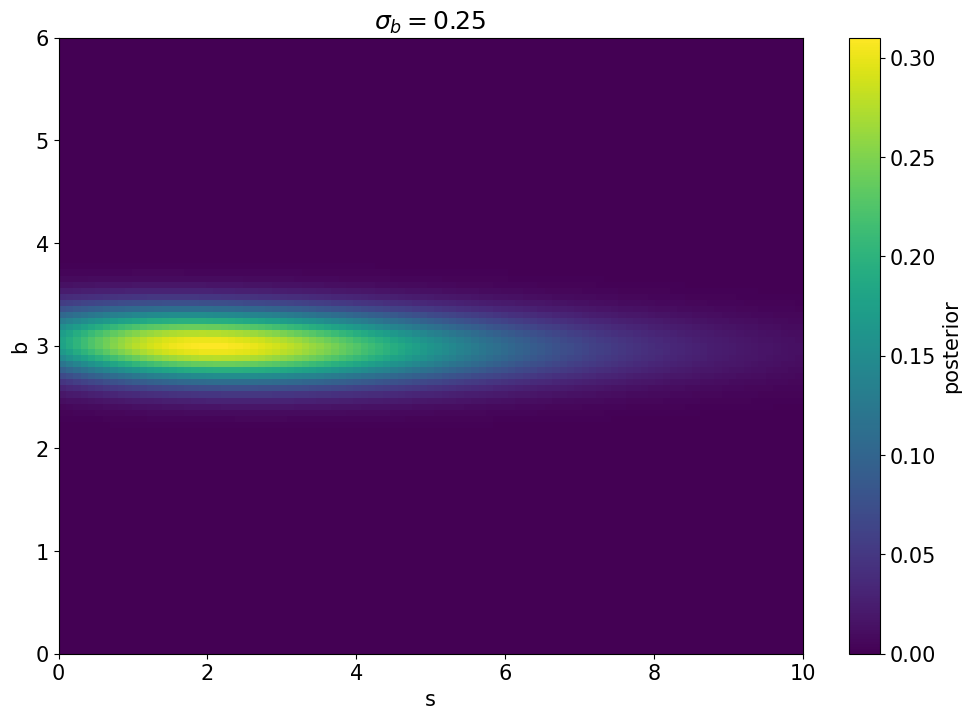

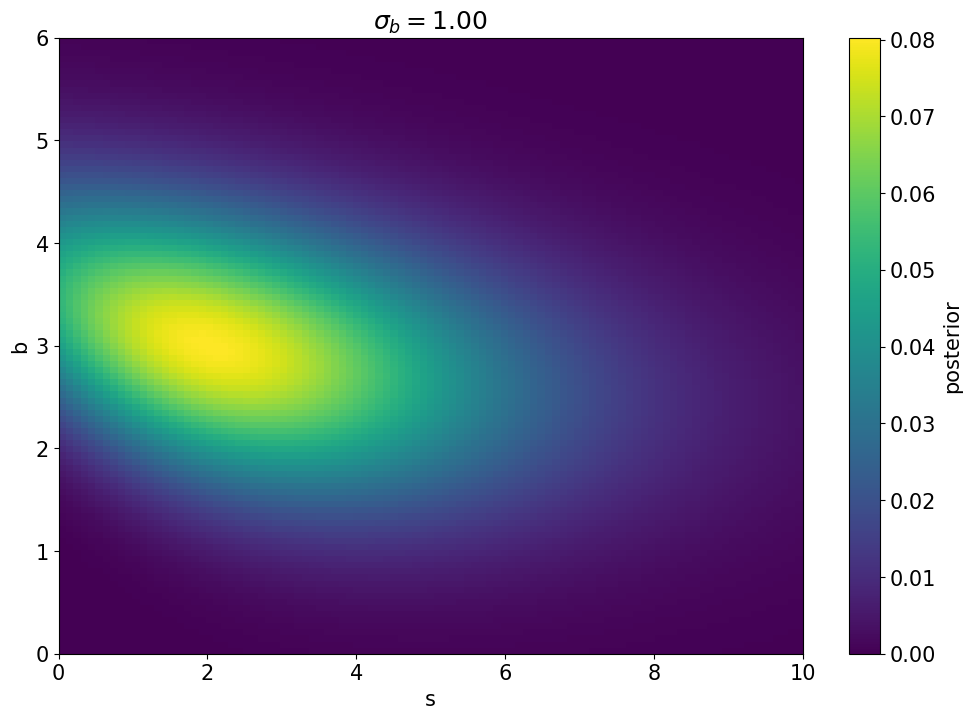

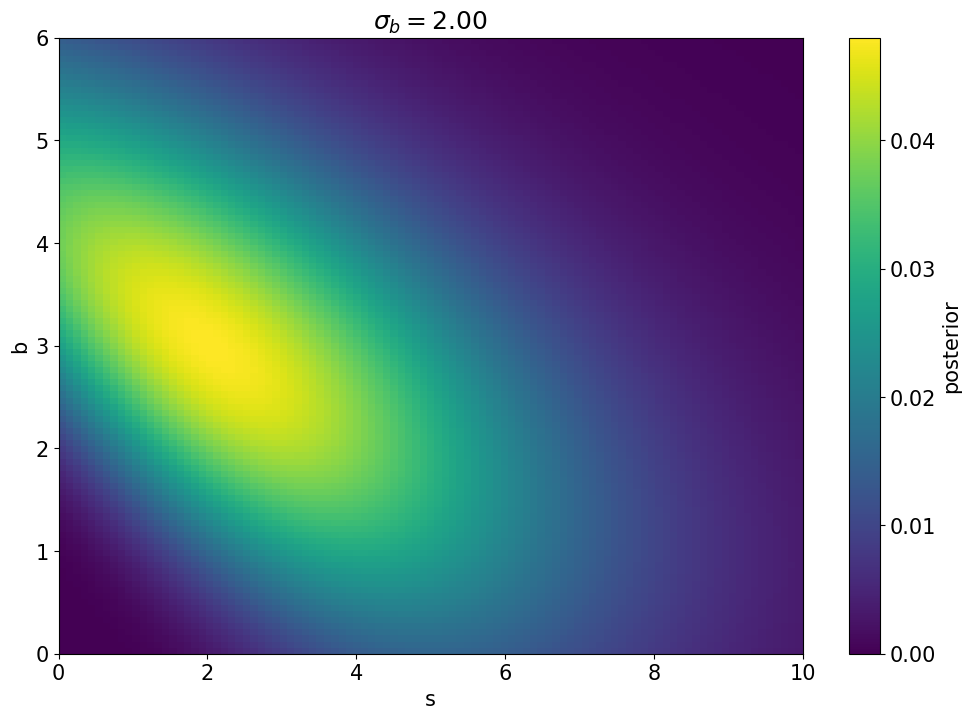

In [12]:
n = 5
bbar = 3
for sigmab in [0.25,1.0,2.0]:
    plt.figure()
    s = np.linspace(0,10,101)
    b = np.linspace(0,6,101)
    sv,bv = np.meshgrid(s,b)
    plt.title(r'$\sigma_b = %.2f$'%sigmab)
    plt.hist2d(sv.flatten(),bv.flatten(),weights = posterior(model_constraint_bayes,n=n,s=s,b=b,bbar=bbar,sigmab=sigmab,TwoD=True).flatten(),bins=[len(s),len(b)])
    plt.colorbar().set_label('posterior',fontsize=15)
    plt.xlabel('s',fontsize=15)
    plt.ylabel('b',fontsize=15)

#### ROOT - RooStats

In [13]:
# It is not possible to solve this exercise with ROOT - RooStats, since...
# BayesianCalculator::GetPosteriorPdf - current implementation works only on 1D intervals

### Posterior with constraint (1D)

- If we select $s$ as the only parameter of interest, we can integrate out $b$
\begin{equation}
\mathrm{posterior}(s|n,\overline{b}) = \frac{ \int_0^\infty \mathcal{L}(s , b' |n) \mathcal{G}(b'|\overline{b},\sigma_b) \, db'}{\int_0^\infty \int_0^\infty \mathcal{L}(s' , b' | n ) \mathcal{G}(b'|\overline{b},\sigma_b) \, ds' db'}
\end{equation}

#### Python

Text(0, 0.5, 'posterior')

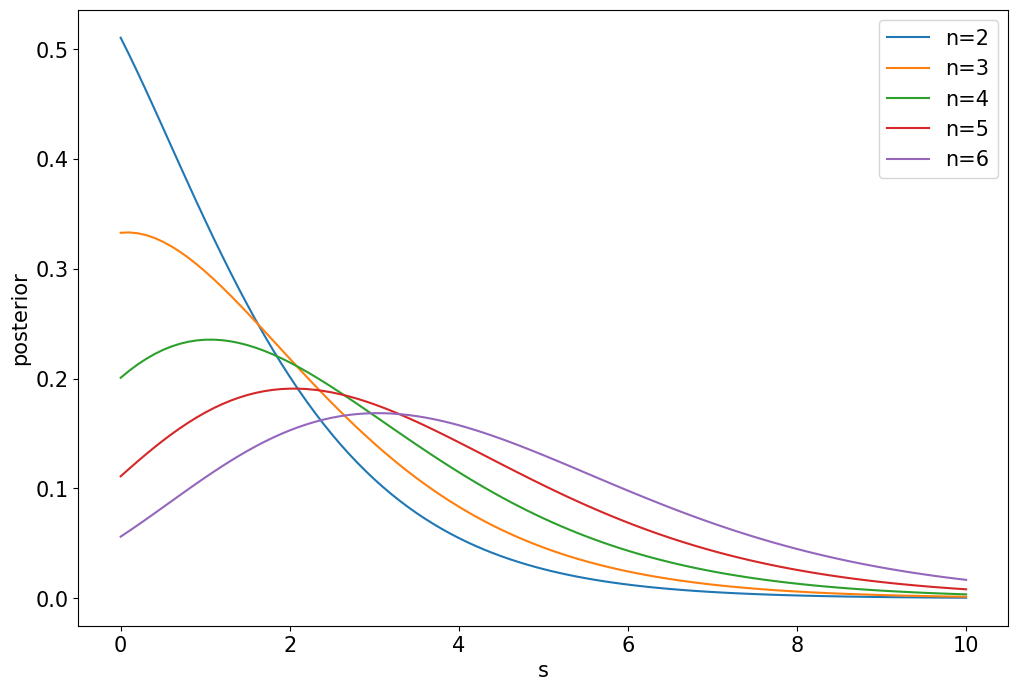

In [14]:
plt.figure()
s = np.linspace(0,10,101)
for n in range(2,7):
    plt.plot(s,posterior(model=model_constraint_bayes,n=n,s=s,b=np.linspace(0,6,81),bbar=bbar,sigmab=0.5),label='n=%d'%n)
plt.legend(loc='best')
plt.xlabel('s',fontsize=15)
plt.ylabel('posterior',fontsize=15)

#### ROOT - RooStats

[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction :  nll value 1.92056 poi value = 1e-05
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction : minimum of NLL vs POI for POI =  1e-05 min NLL = 1.92056
[#1] INFO:NumericIntegration -- RooRealIntegral::init(_posteriorPdf_posteriorfunction_from_nll_poisson_data_Int[s]) using numeric integrator RooIntegrator1D to calculate Int(s)
[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction :  nll value 12.8369 poi value = 15.92
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction : minimum of NLL vs POI for POI =  1e-05 min NLL = 1.66366
[#1] INFO:NumericIntegration -- RooRealIntegral::init(_posteriorPdf_posteriorfunction_from_nll_poisson_data_Int[s]) using numeric integrator RooIntegrator1D to calculate Int(s)
[#

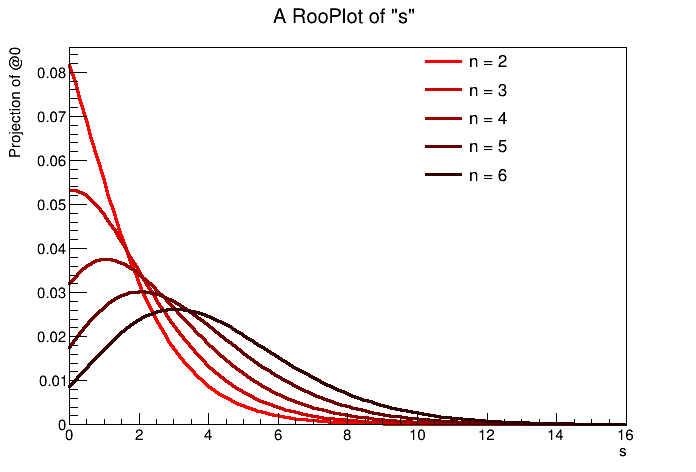

In [15]:
modelc.SetPdf('poisson')
modelc.SetParametersOfInterest('s')
modelc.SetPriorPdf('prior')
modelc.SetNuisanceParameters('b')

frame = ws.var('s').frame()
legend = ROOT.TLegend(0.6,0.6,0.9,0.9)
legend.SetBorderSize(0)
legend.SetFillStyle(0)
c = ROOT.TCanvas()
for i,n in enumerate(range(2,7)): # number of observed events
    ws.var('n').setVal(n)
    ws.var('n').setConstant()
    data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
    data.add(ROOT.RooArgSet(ws.var('n')))
    bcalc = ROOT.RooStats.BayesianCalculator(data,modelc)
    post = bcalc.GetPosteriorPdf()
    curve = post.plotOn(frame,ROOT.RooFit.LineColor(ROOT.kRed+i),ROOT.RooFit.LineWidth(3),ROOT.RooFit.Name('n%d'%n))
    legend.AddEntry(frame.findObject('n%d'%n),'n = %d'%n,'l')
ws.var('n').setConstant(False)
frame.Draw()
legend.Draw()
c.Draw()

### How the background knowledge impacts on the signal estimate

- The physical measurements profit of a better understanding and determination of the background

#### Python

Text(0, 0.5, 'posterior')

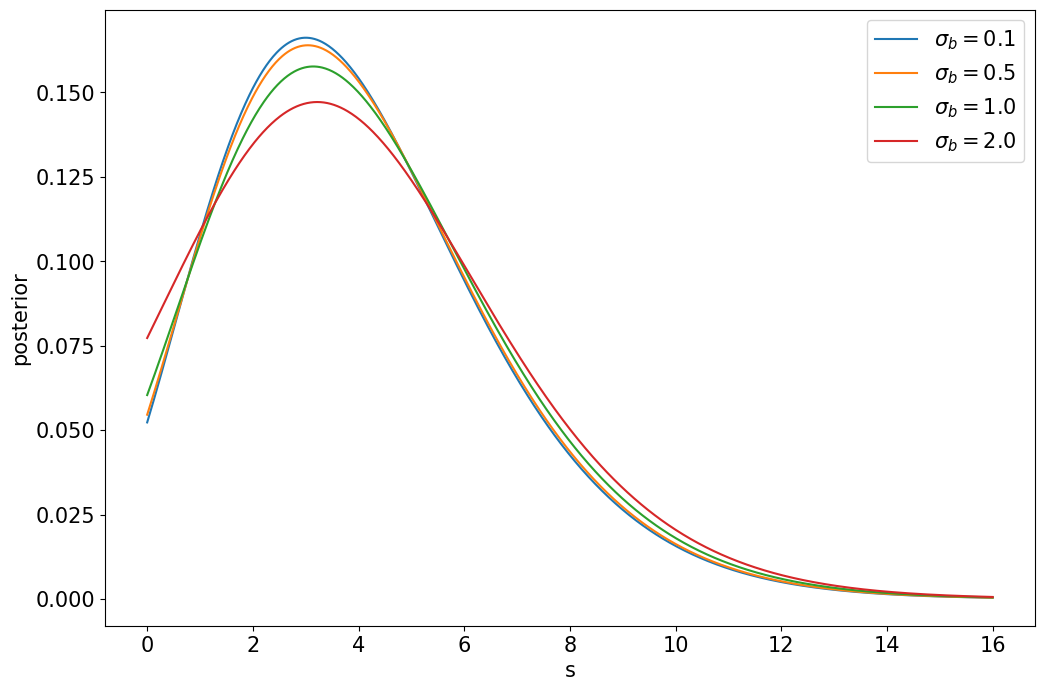

In [16]:
n=6

plt.figure()
s = np.linspace(0,16,1001)
for sigmab in [0.1,0.5,1.0,2.0]:
    post = posterior(model=model_constraint_bayes,n=6,s=s,bbar = bbar,sigmab = sigmab,b = np.linspace(0,12,1001))
    plt.plot(s,post,label='$\sigma_b = %.1f$'%sigmab)
plt.legend(loc='best')
plt.xlabel('s',fontsize=15)
plt.ylabel('posterior',fontsize=15)

#### ROOT - RooStats

[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction :  nll value 7.85793 poi value = 15.92
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction : minimum of NLL vs POI for POI =  3.00009 min NLL = 1.82869
[#1] INFO:NumericIntegration -- RooRealIntegral::init(_posteriorPdf_posteriorfunction_from_nll_poisson_data_Int[s]) using numeric integrator RooIntegrator1D to calculate Int(s)
[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction :  nll value 7.86801 poi value = 15.92
[#1] INFO:Eval -- BayesianCalculator::GetPosteriorFunction : minimum of NLL vs POI for POI =  2.98449 min NLL = 1.82869
[#1] INFO:NumericIntegration -- RooRealIntegral::init(_posteriorPdf_posteriorfunction_from_nll_poisson_data_Int[s]) using numeric integrator RooIntegrator1D to calculate Int(s

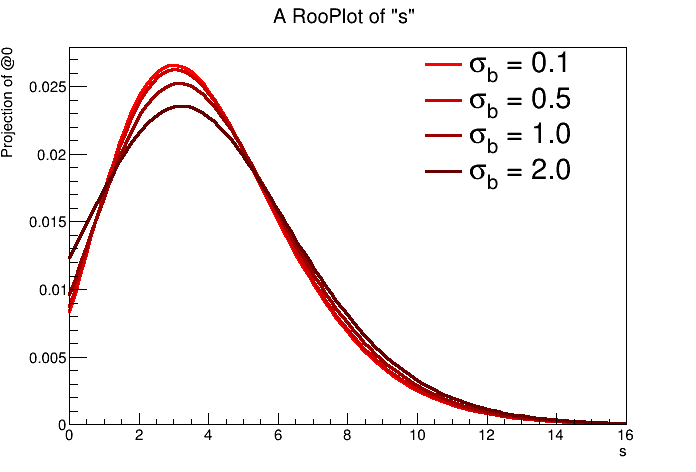

In [17]:
c = ROOT.TCanvas()
frame = ws.var('s').frame()
n=6
ws.var('n').setVal(n)
ws.var('n').setConstant()
ws.var('b').setVal(3)
ws.var('b').setConstant(False)

modelc = ROOT.RooStats.ModelConfig(ws)
modelc.SetPdf('poisson')
modelc.SetParametersOfInterest('s')
modelc.SetPriorPdf('prior')
modelc.SetNuisanceParameters('b')

data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
data.add(ROOT.RooArgSet(ws.var('n')))

legend = ROOT.TLegend(0.6,0.6,0.9,0.9)
legend.SetBorderSize(0)
legend.SetFillStyle(0)

for i,sigmab in enumerate([0.1,0.5,1.0,2.0]):
    ws.var('sigmab').setVal(sigmab)
    bcalc = ROOT.RooStats.BayesianCalculator(data,modelc)
    post = bcalc.GetPosteriorPdf()
    curve = post.plotOn(frame,ROOT.RooFit.LineColor(ROOT.kRed+i),ROOT.RooFit.LineWidth(3),ROOT.RooFit.Name('sigmab%.2f'%sigmab))
    legend.AddEntry(frame.findObject('sigmab%.2f'%sigmab),'#sigma_{b} = %.1f'%sigmab,'l')

frame.Draw()
legend.Draw()
c.Draw()

## Frequentist approach

- Define test statistic
\begin{equation}
t = − 2 \log \frac{\mathcal{L}(s , b )}{\mathcal{L}(\hat{s} , \hat{b} )}
\end{equation}
where $\hat{s}$, $\hat{b}$ identify the values for which we have the maximum $\mathcal{L}(s,b)$, obtained from the maximum likelihood fit

### Frequentist interval

- In the frequentist approach we use the Wilk’s theorem to convert the test statistic in significance (asymptotic limit) and then calculate intervals. This approach is valid only in the limit of high statistics, but we will use it in this exercises for didactic purposes

- Confidence intervals calculated via the confidence belt with pseudo-experiments is always a valid approach, at the price of a much more computationally expensive task

- When the background is not constrained, the degree of freedom is $s + b$ and we can't disentangle the two contributions

- The best yields estimate is in the region where the test statistic is low and it is identified by $s + b=n=5$ (5 is the number of observed events)

#### Python

Text(0, 0.5, 'b')

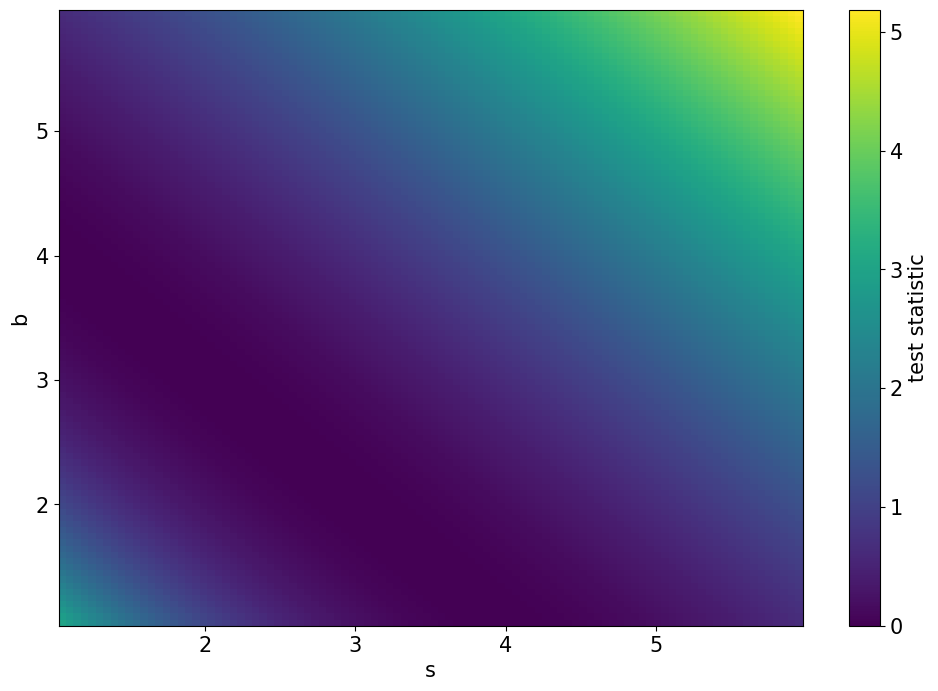

In [18]:
n=5
res=minimize(partial(nll_2d,model_poisson_2d,n),x0=(3,2),bounds=[(0,np.inf),(0,np.inf),])
bestNLL = res.fun

b = np.linspace(1,6,101)
b = 0.5*(b[1:]+b[:-1])
s = np.linspace(1,6,101)
s = 0.5*(s[1:]+s[:-1])
sv, bv = np.meshgrid(s,b)

t = testStatistic(model = model_poisson, n=n, s=sv, b=bv, bestNLL = bestNLL)
plt.hist2d(sv.flatten(),bv.flatten(),weights=t.flatten(),bins=[100,100])
plt.colorbar().set_label('test statistic',fontsize=15)
plt.xlabel('s',fontsize=15)
plt.ylabel('b',fontsize=15)

#### ROOT - RooStats

[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- 
  RooFitResult: minimized FCN value: 1.7403, estimated distance to minimum: 6.99907e-08
                covariance matrix quality: Full matrix, but forced positive-definite
                Status : MINIMIZE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     b    5.1301e-04 +/-  9.98e+00
                     s    4.9994e+00 +/-  1.32e+01

[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_poisson_data_Profile[s,b]) Creating instance of MINUIT
[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_po

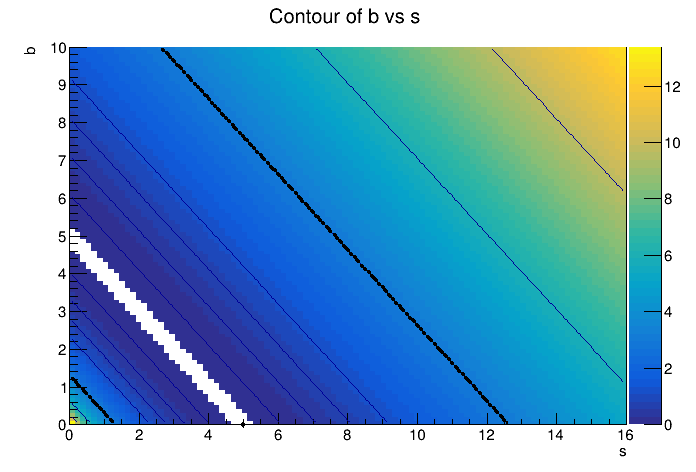

In [19]:
import ROOT
n = 5
data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
ws.var('n').setVal(n)
data.add(ROOT.RooArgSet(ws.var('n')))

pdf = ws.pdf('poisson')

pl = ROOT.RooStats.ProfileLikelihoodCalculator(data,pdf,ROOT.RooArgSet(ws.var('s'),ws.var('b')))
interval = pl.GetInterval()

c = ROOT.TCanvas()
ROOT.SetOwnership(c,False)
intervalplot = ROOT.RooStats.LikelihoodIntervalPlot(interval)
intervalplot.SetNPoints(100*100)
intervalplot.Draw('hist nominuit')
c.Draw()

### Test Statistic with constraint

- The likelihood $\mathcal{L}$ is modified as
\begin{equation}
\mathcal{L}(s,b|n,\overline{b}) = \mathcal{P}(n|s+b) \cdot \mathcal{G}(\overline{b}|b,\sigma_b)
\end{equation}
and the test statistic $t$ is calculated accordingly

- With respect to the bayesian case, $b$ is not distributed with a gaussian shape, but it is a true unkown value to be measured. The external measurement $\overline{b}$ is sampled from a gaussian distribution where $b$ represents the mean

- Practically, in this particular case, since the gaussian is symmetric with respect to $b$ and $\overline{b}$, the bayesian and frequentist likelihoods are equivalent, but conceptually different

#### Python

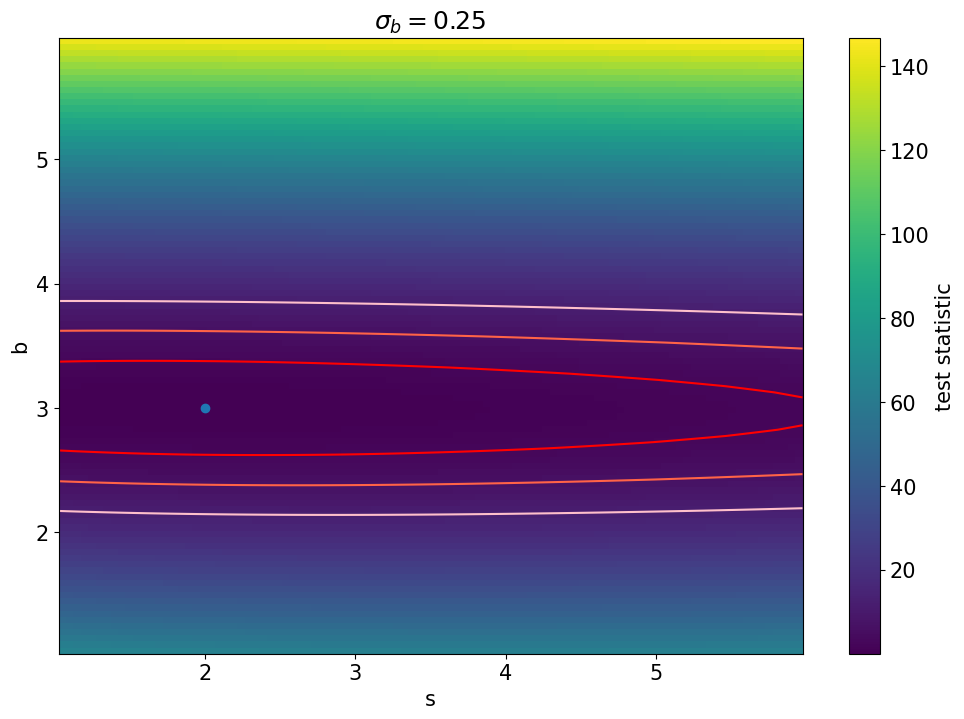

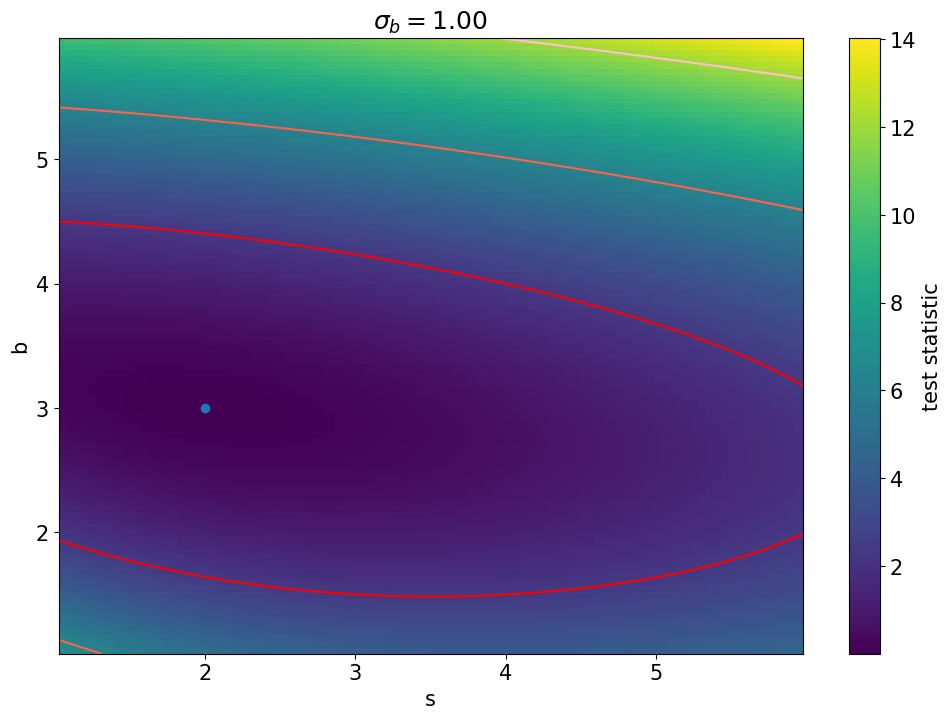

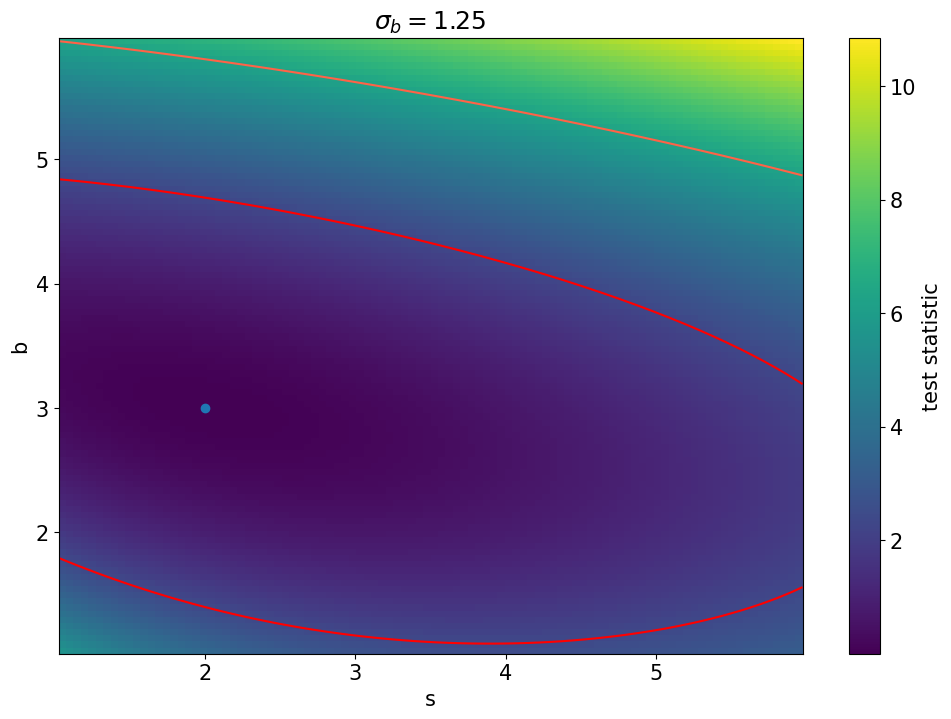

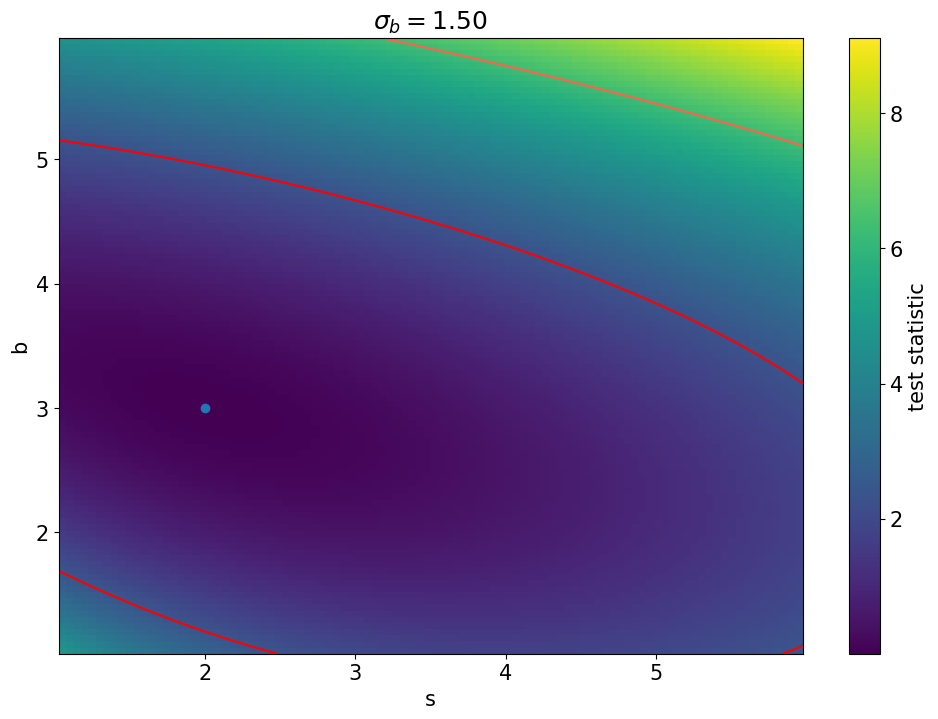

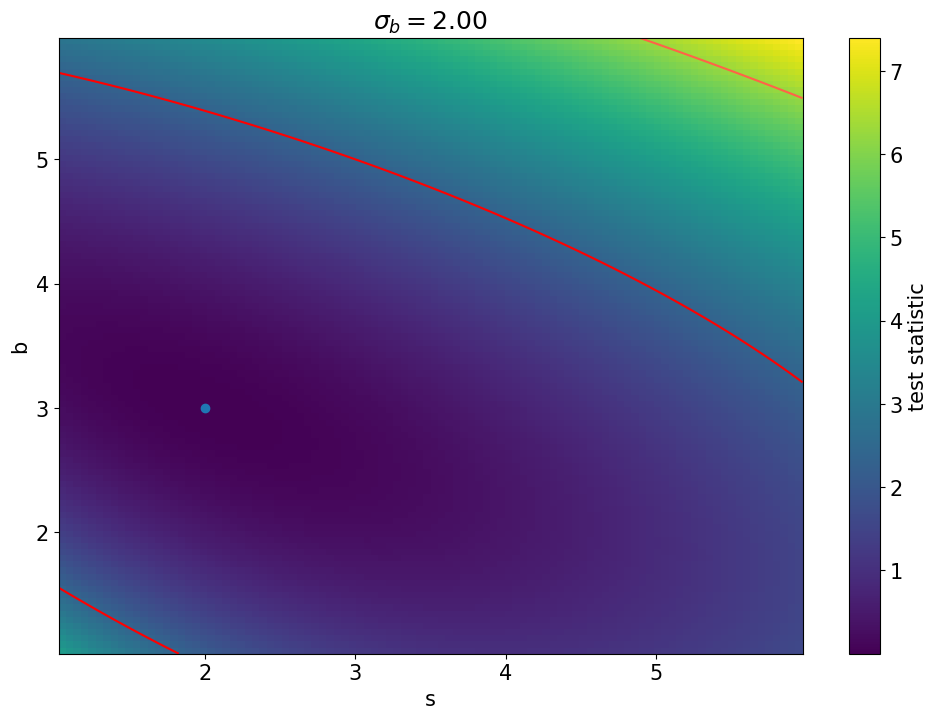

In [20]:
n=5
b = np.linspace(1,6,101)
b = 0.5*(b[1:]+b[:-1])
s = np.linspace(1,6,101)
s = 0.5*(s[1:]+s[:-1])
sv, bv = np.meshgrid(s,b)

from scipy.stats import chi2
coverage_sigma1 = norm.cdf(1)-norm.cdf(-1)
coverage_sigma2 = norm.cdf(2)-norm.cdf(-2)
coverage_sigma3 = norm.cdf(3)-norm.cdf(-3)

for sigmab in [0.25,1.,1.25,1.5,2.0]:
    res=minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(0,1),bounds=[(0,np.inf),(0,np.inf),])
    bestNLL = res.fun
    t = testStatistic(model = model_constraint_freq, n=n, s=sv, b=bv, bestNLL = bestNLL, bbar = bbar, sigmab = sigmab)
    plt.figure()
    plt.title(r'$\sigma_b=%.2f$'%sigmab)
    plt.hist2d(sv.flatten(),bv.flatten(),weights=t.flatten(),bins=[100,100])
    plt.colorbar().set_label(label='test statistic',fontsize=15)
    plt.contour(s,b,t,[chi2(2).ppf(coverage_sigma1),chi2(2).ppf(coverage_sigma2),chi2(2).ppf(coverage_sigma3)],colors=['red','tomato','pink'])
    plt.scatter(res.x[0],res.x[1])
    plt.xlabel('s',fontsize=15)
    plt.ylabel('b',fontsize=15)

#### ROOT - RooStats


[#1] INFO:Minimization -- createConstraintTerm: caching constraint set under name CACHE_CONSTR_OF_PDF_model_constraint_FOR_OBS_n with 1 entries
[#1] INFO:Minimization --  Including the following constraint terms in minimization: (constr_b)
[#1] INFO:Minimization -- The following global observables have been defined and their values are taken from the model: ()
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_constraint_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (poisson)
[#1] INFO:Minimization -- 
  RooFitResult: minimized FCN value: 1.7403, estimated distance to min

Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: _hist2D__s_b (Potential memory leak).


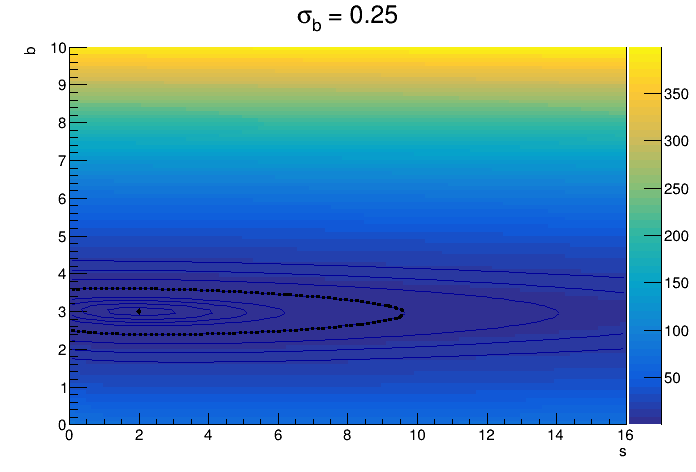

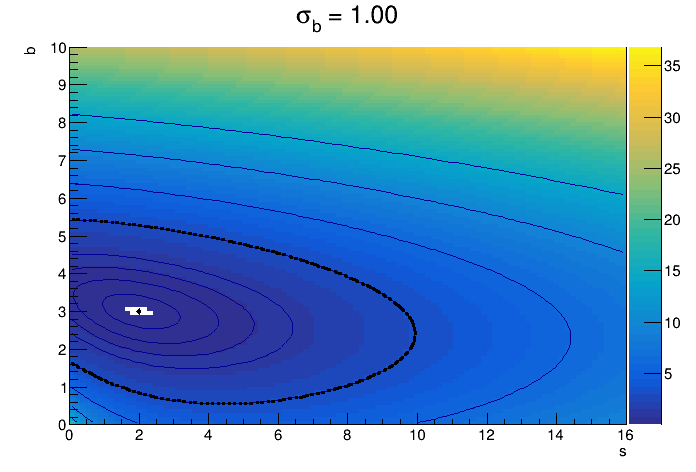

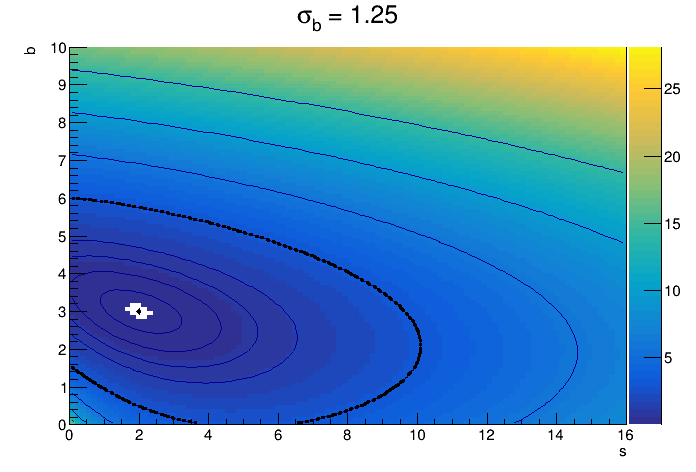

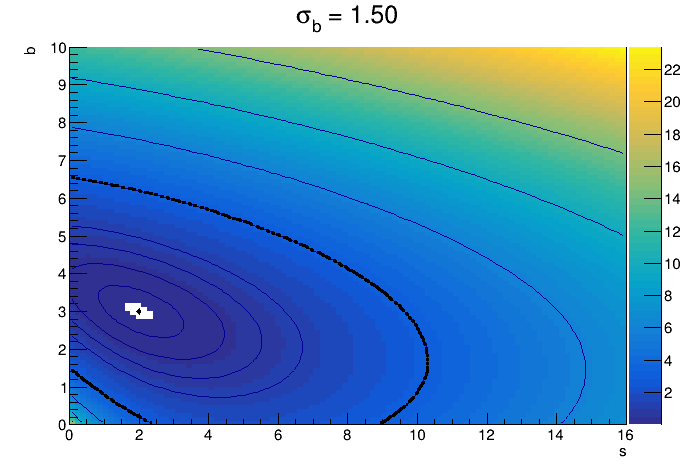

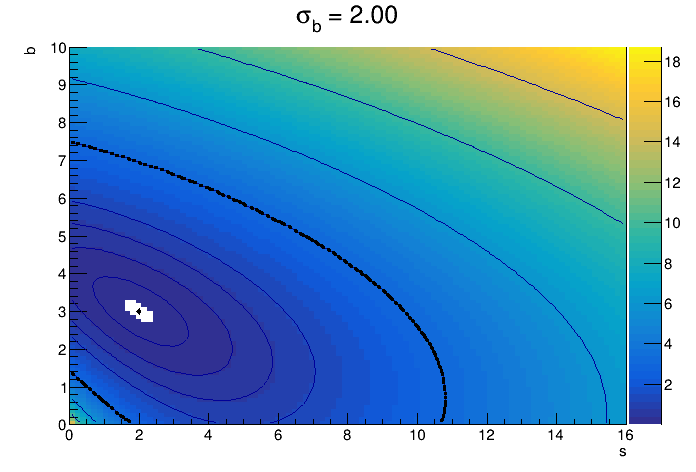

In [21]:
n = 5
data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
ws.var('n').setVal(n)
data.add(ROOT.RooArgSet(ws.var('n')))

ws.factory('Gaussian::constr_b(3,b,sigmab)')
ws.factory('PROD::model_constraint(poisson,constr_b)')
modelc.SetPdf('model_constraint')
modelc.SetParametersOfInterest('s,b')

for sigmab in [0.25,1,1.25,1.5,2.0]:
    ws.var('sigmab').setVal(sigmab)
    ws.var('sigmab').setConstant()
    pl = ROOT.RooStats.ProfileLikelihoodCalculator(data,modelc)
    interval = pl.GetInterval()
    c = ROOT.TCanvas('c'+str(sigmab),'c'+str(sigmab))
    ROOT.SetOwnership(c,False)
    intervalplot = ROOT.RooStats.LikelihoodIntervalPlot(interval)
    intervalplot.SetTitle('#sigma_{b} = %.2f'%sigmab)
    intervalplot.SetNPoints(100*100)
    intervalplot.Draw('hist nominuit')
    c.Draw()
ws.var('sigmab').setConstant(False)

### Profiled Likelihood ratio

- The number of background yield $b$ is considered as nuisance parameter and is profiled in the test statistic, i.e. for each value of s an optimal value of $\hat{\hat{b}}$ is obtained minimazing the negative log likelihood
\begin{equation}
t = − 2 \log \frac{\mathcal{L}(s , \hat{\hat{b}} )}{\mathcal{L}(\hat{s} , \hat{b} )}
\end{equation}

#### Python

1.642374415149818
sigmab = 0.25, upper limit = 5.46
sigmab = 1.00, upper limit = 5.63
sigmab = 1.25, upper limit = 5.75
sigmab = 1.50, upper limit = 5.88
sigmab = 2.00, upper limit = 6.20


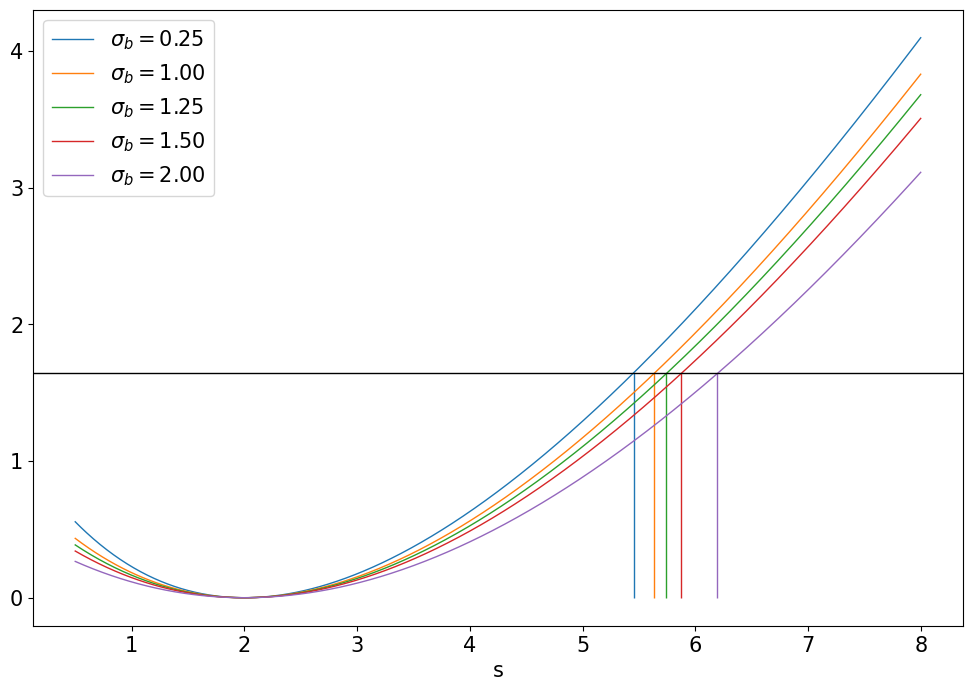

In [24]:
n=5
limit = chi2(1).ppf(0.8) # 90% one sided CL
print(limit)
s = np.linspace(0.5,8,751)
for sigmab in [0.25,1.,1.25,1.5,2.0]:
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(2,3),bounds=[(0,np.inf),(0,np.inf),])
    bestNLL = res.fun
    t = np.array([])
    for si in s:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(3,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
    p = plt.plot(s,t,label=r'$\sigma_b=%.2f$'%sigmab,lw=1)
    idx = (t>limit).argmax()
    upper_limit = 0.5*(s[idx]+s[idx-1])
    print('sigmab = %.2f, upper limit = %.2f'%(sigmab,upper_limit))
    plt.vlines(upper_limit,0,limit,lw=1,color=p[0].get_color())
plt.xlabel('s',fontsize=15)
plt.axhline(limit,color='black',lw=1)
plt.legend(loc='best')

#### ROOT - RooStats

sigma_b = 0.25, upper limit on s at 90%CL = 16.00
sigma_b = 1.00, upper limit on s at 90%CL = 16.00
sigma_b = 1.25, upper limit on s at 90%CL = 16.00
sigma_b = 1.50, upper limit on s at 90%CL = 16.00
sigma_b = 2.00, upper limit on s at 90%CL = 16.00

[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 1 entries
[#1] INFO:Minimization --  Including the following constraint terms in minimization: (constr_b)
[#1] INFO:Minimization -- The following global observables have been defined and their values are taken from the model: ()
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_constraint_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const opti

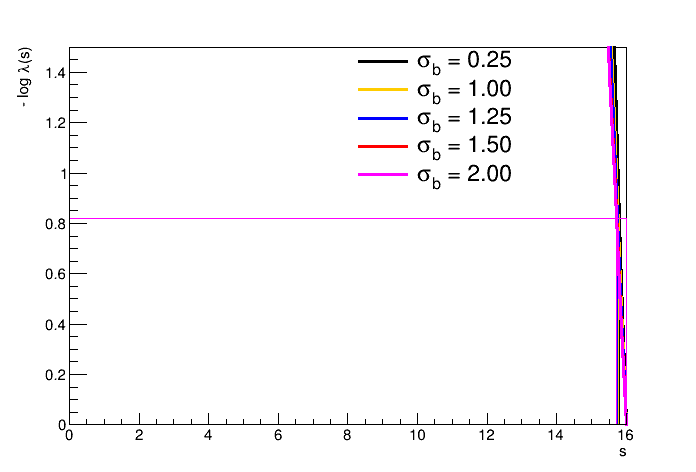

In [23]:
n = 10000
data = ROOT.RooDataSet('data','data',ROOT.RooArgSet(ws.var('n')))
ws.var('n').setVal(n)
data.add(ROOT.RooArgSet(ws.var('n')))

c = ROOT.TCanvas()
ROOT.SetOwnership(c,False)
colors = [ROOT.kBlack,ROOT.kOrange,ROOT.kBlue,ROOT.kRed,ROOT.kMagenta]
legend = ROOT.TLegend(0.5,0.6,0.9,0.9)
legend.SetBorderSize(0)
legend.SetFillStyle(0)

modelc.SetParametersOfInterest('s')
modelc.SetNuisanceParameters('b')

for i,sigmab in enumerate([0.25,1,1.25,1.5,2.0]):
    ws.var('sigmab').setVal(sigmab)
    ws.var('sigmab').setConstant()
    pl_s = ROOT.RooStats.ProfileLikelihoodCalculator(data,modelc)
    interval_s = pl_s.GetInterval()
    interval_s.SetConfidenceLevel(0.8) # 90% one sided CL
    intervalplot_s = ROOT.RooStats.LikelihoodIntervalPlot(interval_s)
    intervalplot_s.SetMaximum(1.5)
    intervalplot_s.SetNPoints(100)
    intervalplot_s.SetLineColor(colors[i])
    intervalplot_s.SetContourColor(colors[i])
    intervalplot_s.Draw('same' if i!=0 else '')
    intervalplot_s.Print('v')
    h = intervalplot_s.GetPlottedObject()
    legend.AddEntry(h.getCurve('nll_model_constraint_data_with_constr_Profile[s]_Norm[s]'),'#sigma_{b} = %.2f'%sigmab,'l')
    print('sigma_b = %.2f, upper limit on s at 90%%CL = %.2f'%(sigmab,interval_s.UpperLimit(ws.var('s'))))
legend.Draw()
c.Draw()